In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import numpy as np
from skimage.restoration import unwrap_phase
from temgym_core.components import Detector
from temgym_core.utils import wavelength2energy
from temgym_core.gaussian import GaussianRayBeta
from temgym_core.gaussian_taylor import (
    AberratedLens, 
    FreeSpaceParaxial, 
    SigmoidAperture,
    run_to_end,
    evaluate_gaussian_packets_jax_scan
)
from temgym_core.utils import fibonacci_spiral

jax.config.update("jax_enable_x64", True)

Single Beam Case - Not realistic parameters - We are setting the scale of 1 = 1 angstrom for simplicity for now. 

In [2]:
# Simulation Width
W = 60
Nx = Ny = 512
dx = W/Nx
dy = W/Ny
grid = Detector(z=0.0, pixel_size=(dx, dy), shape=(Nx, Ny))
coords = grid.coords
X, Y = coords[:,0].reshape(grid.shape), coords[:,1].reshape(grid.shape)
x, y = X[0,:], Y[:,0]

# Aberrated Lens Parameters
f = 100
C_sph = 1e-11
C_coma_x = 1e-4
C_coma_y = 2e-3
lens = AberratedLens(z=0.0, focal_length=f, C_sph=C_sph, C_coma_x=C_coma_x, C_coma_y=C_coma_y)


# Simulation wavelength and k number
wavelength = 0.25
k0 = 2 * np.pi / wavelength

# Optical path length surface of lens and it's phase shift for this wavelength
opl_exact = np.real(lens.complex_action(coords).reshape(grid.shape))
phase_exact = np.angle(np.exp(1j * k0 * jnp.real(opl_exact)).reshape(grid.shape))

Text(0, 0.5, 'y')

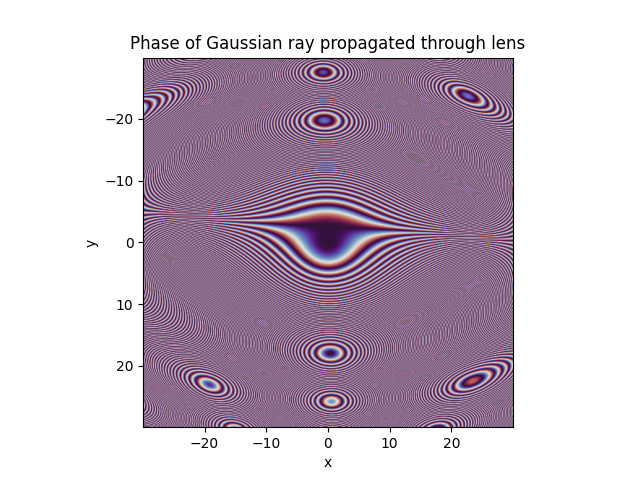

In [3]:
plt.figure()
plt.imshow(phase_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='twilight', vmin=-np.pi, vmax=np.pi)
plt.title('Phase of Gaussian ray propagated through lens')
plt.xlabel('x')
plt.ylabel('y')

In [4]:
angstroms_to_metres = 1e-10
voltage = wavelength2energy(wavelength * angstroms_to_metres) # wavelength in meters as this function expects SI units
k0 = 2 * jnp.pi / wavelength
num_rays = 1
rx, ry = 2, 0.0
C0 = jnp.ones(num_rays)*(1.0 + 0.0j)
eta = jnp.full((num_rays, 2), 0.0+0.0j)
w0 = 4 # Beam waist
q = -1j * (2.0 / (k0 * w0**2))
Q_inv = jnp.array([[q, 0.0], [0.0, q]])
Q_inv = jnp.tile(Q_inv, (num_rays, 1, 1))
voltage = jnp.full((num_rays,), voltage)

ray_in = GaussianRayBeta(x=rx, 
                         y=ry, 
                         dx=0.0, 
                         dy=0.0, 
                         z=0.0, 
                         pathlength=0.0,
                         Q_inv=Q_inv, 
                         eta=eta, 
                         C=C0,
                         voltage=voltage)


ray_in=ray_in.to_vector()
ray_out = run_to_end(ray_in, [lens])
E_gaussian = evaluate_gaussian_packets_jax_scan(ray_out, grid, batch_size=1)

phase_gaussian = np.angle(E_gaussian)
opl_gaussian = unwrap_phase(phase_gaussian) / ray_out.k

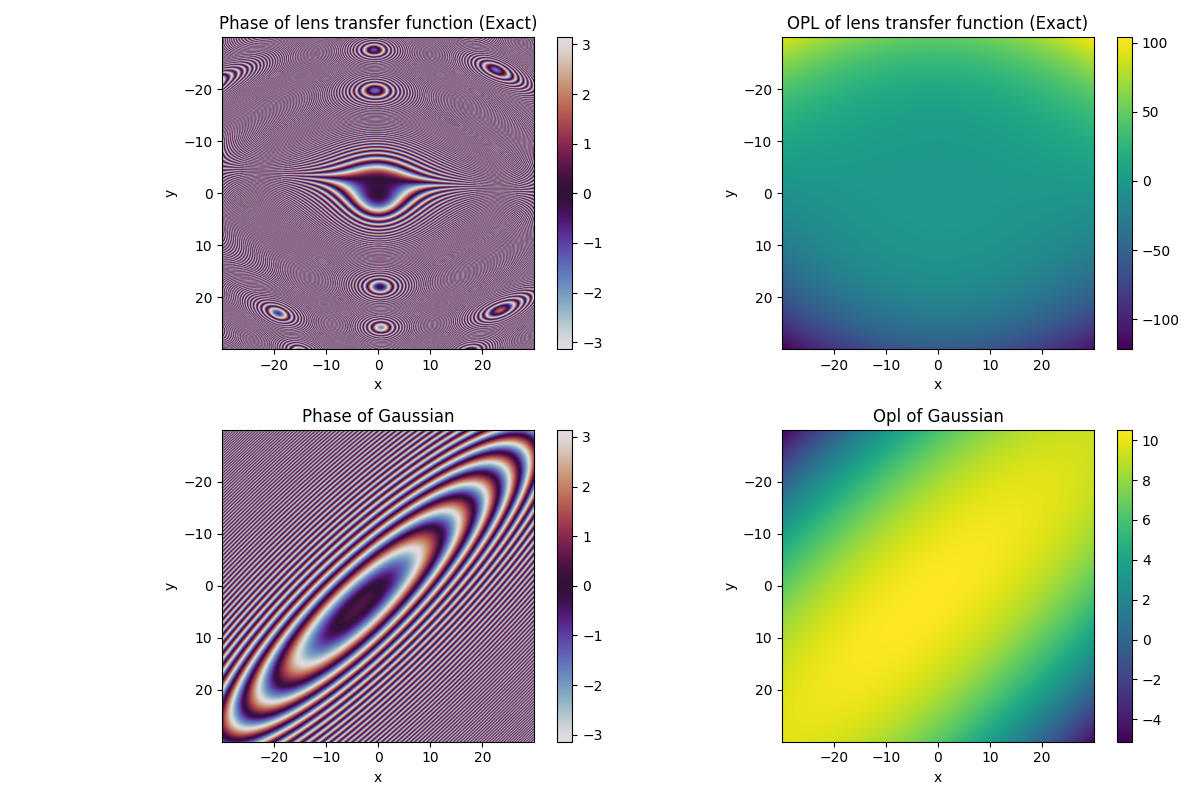

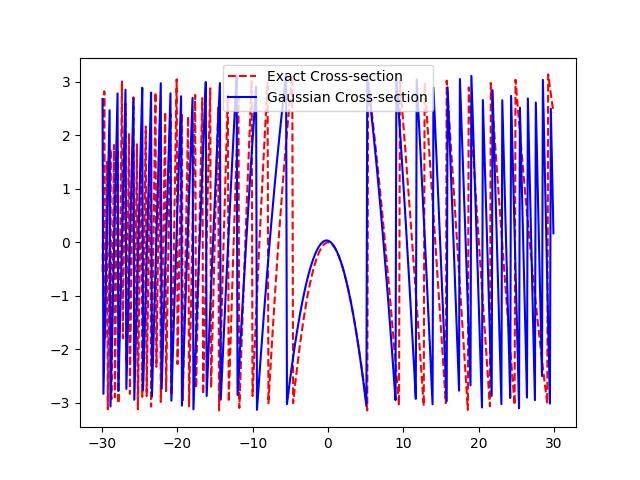

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Phase of lens transfer function
im0 = axs[0, 0].imshow(phase_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[0, 0].set_title('Phase of lens transfer function (Exact)')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

# Optical path length of lens transfer function
im1 = axs[0, 1].imshow(opl_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='viridis')
axs[0, 1].set_title('OPL of lens transfer function (Exact)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

# Phase of Gaussian
im2 = axs[1, 0].imshow(phase_gaussian, extent=[x[0], x[-1], y[0], y[-1]], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[1, 0].set_title('Phase of Gaussian')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
plt.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)

# OPL of Gaussian
im3 = axs[1, 1].imshow(opl_gaussian, extent=[x[0], x[-1], y[0], y[-1]], cmap='viridis')
axs[1, 1].set_title('Opl of Gaussian')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
plt.colorbar(im3, ax=axs[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
# Cross section plots of exact vs Gaussian
y_cross = Ny // 2
plt.figure()
plt.plot(x, phase_exact[y_cross, :], 'r--', label='Exact Cross-section')
plt.plot(x, phase_gaussian[y_cross, :], 'b-', label='Gaussian Cross-section')
plt.legend()



n_beams case

In [36]:
voltage = wavelength2energy(wavelength * 1e-10)
print(voltage)
k0 = 2 * jnp.pi / wavelength
num_rays = 50000

rx, ry = fibonacci_spiral(num_rays, radius=W)
num_rays = len(rx)

C0 = jnp.ones(num_rays)*(1.0 + 0.0j)
eta = jnp.full((num_rays, 2), 0.0+0.0j)
q = -1j * (2.0 / (k0 * w0**2))
Q_inv = jnp.array([[q, 0.0], [0.0, q]])
Q_inv = jnp.tile(Q_inv, (num_rays, 1, 1))
voltage = jnp.full((num_rays,), voltage)

ray_in = GaussianRayBeta(x=rx, 
                         y=ry, 
                         dx=0.0, 
                         dy=0.0, 
                         z=0.0, 
                         pathlength=0.0,
                         Q_inv=Q_inv, 
                         eta=eta, 
                         C=C0,
                         voltage=voltage)


ray_in=ray_in.to_vector()
ray_out = run_to_end(ray_in, [lens])
E_gaussian = evaluate_gaussian_packets_jax_scan(ray_out, grid, batch_size=1)
phase_gaussian = np.angle(E_gaussian).reshape(grid.shape)
opl_gaussian = unwrap_phase(phase_gaussian) / ray_out.k[0]

2400.952524012268


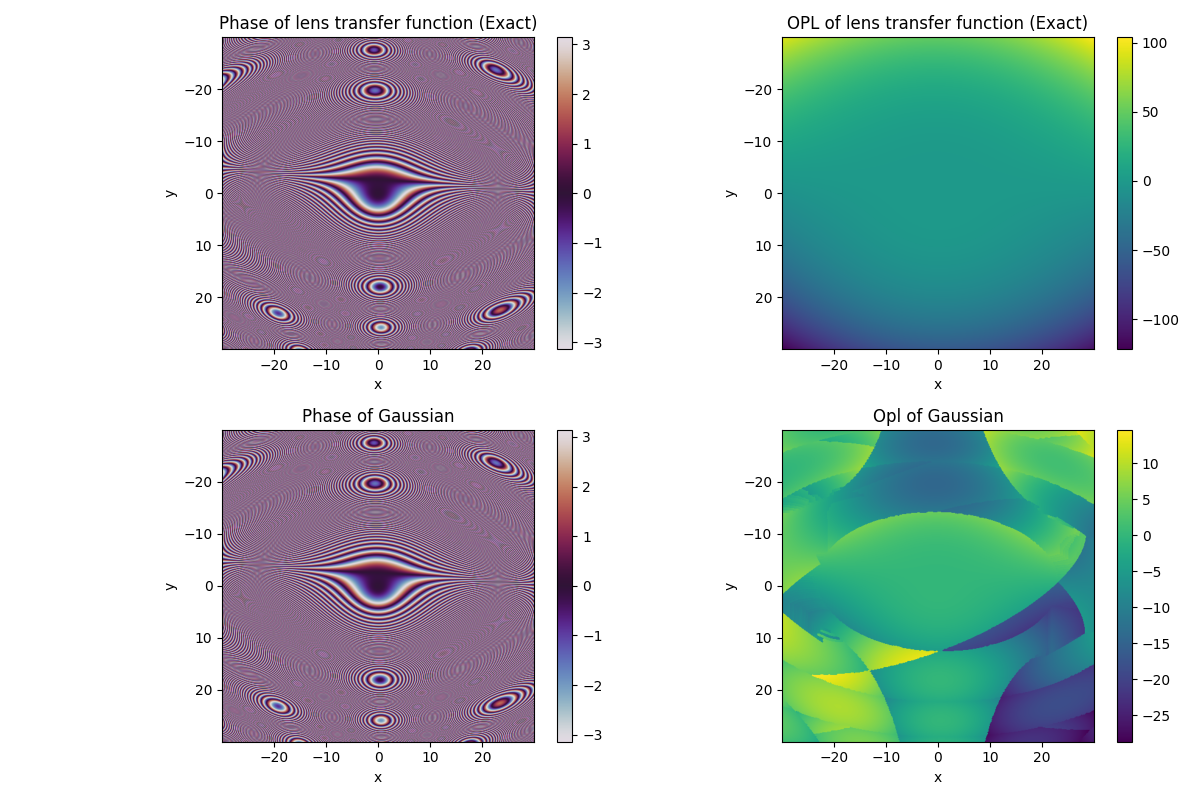

/tmp/ipykernel_3668964/2443951794.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


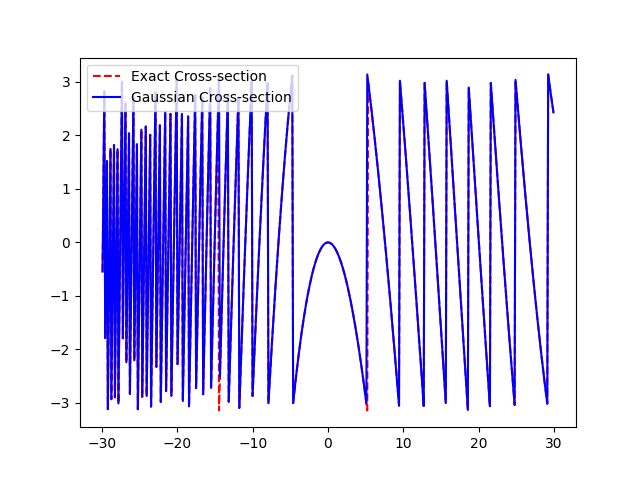

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Phase of lens transfer function
im0 = axs[0, 0].imshow(phase_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[0, 0].set_title('Phase of lens transfer function (Exact)')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
plt.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)

# Optical path length of lens transfer function
im1 = axs[0, 1].imshow(opl_exact, extent=[x[0], x[-1], y[0], y[-1]], cmap='viridis')
axs[0, 1].set_title('OPL of lens transfer function (Exact)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
plt.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

# Phase of Gaussian
im2 = axs[1, 0].imshow(phase_gaussian, extent=[x[0], x[-1], y[0], y[-1]], cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[1, 0].set_title('Phase of Gaussian')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
plt.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)

# OPL of Gaussian
im3 = axs[1, 1].imshow(opl_gaussian, extent=[x[0], x[-1], y[0], y[-1]], cmap='viridis')
axs[1, 1].set_title('Opl of Gaussian')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
plt.colorbar(im3, ax=axs[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
# Cross section plots of exact vs Gaussian
y_cross = Ny // 2
plt.figure()
plt.plot(x, phase_exact[y_cross, :], 'r--', label='Exact Cross-section')
plt.plot(x, phase_gaussian[y_cross, :], 'b-', label='Gaussian Cross-section')
plt.legend()



In [38]:
aperture = SigmoidAperture(radius=W/4, sharpness=10000, z=0.0)
free_space = FreeSpaceParaxial(distance=200.0, z=aperture.z)
components = [aperture, free_space]


ray0 = ray0.derive(x=ray0.x, y=ray0.y)
gp2 = run_to_end(ray0, components)

NameError: name 'ray0' is not defined

In [ ]:
E_input_after_aperture = evaluate_gaussian_packets_jax_scan(aperture(ray0), grid, batch_size=2000)
E_local = evaluate_gaussian_packets_jax_scan(gp2, grid, batch_size=2000)

In [ ]:

plt.figure()
plt.title('Intensity with Aperture Overlay')
plt.axis('equal')
circle = plt.Circle((0, 0), aperture.radius, color='red', fill=False, linestyle='--', linewidth=2)
plt.gca().add_artist(circle)
plt.imshow(np.abs(E_input_after_aperture), cmap='gray', extent=extent)

# Plot the aperture radius on top of the intensity image
plt.figure()
plt.imshow(np.abs(E_local), cmap='gray', extent=extent)


